In [55]:
import matplotlib.pyplot as plt
import mne
import numpy as np
from scipy.stats import ttest_rel
# from braindecode.datasets import MOABBDataset
import mne
import os
from typing import Optional, cast, Union
import numpy as np
from numpy import ndarray
from scipy.stats import pearsonr

from moabb.datasets import Wang2016

In [56]:
dataset = Wang2016()

# subject =list(range(1,11))
subject = [1]

dataset.subject_list = subject

In [57]:
sessions = dataset.get_data(subjects=subject)

Trial data de-meaned and concatenated with a buffer to create continuous data


In [58]:
session_name = "session_0"
run_name = "run_0"
raw_list = [sessions[id][session_name][run_name] for id in sessions]

raw = mne.concatenate_raws(raw_list)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


c:\Users\Sunsun\.virtualenvs\HybridSpeller-q8UBACmb\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


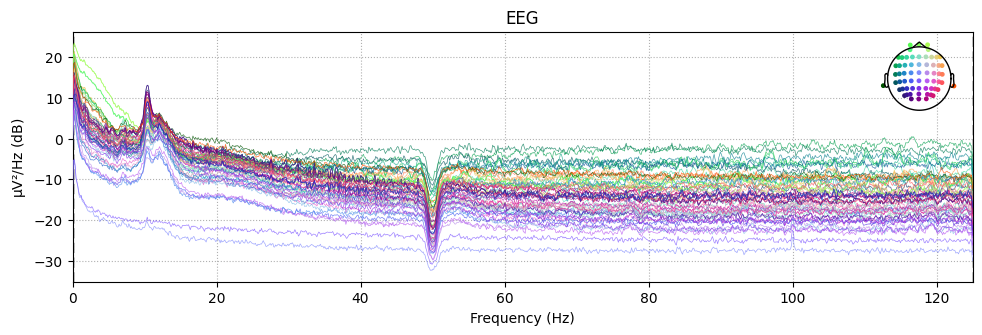

In [59]:
raw.plot_psd()

In [64]:
# Load raw data
# data_path = mne.datasets.ssvep.data_path()
# data_path = moabb.datasets.Nakanishi2015.data_path(subject = 1)

# bids_fname = (data_path)

# raw = mne.io.read_raw_brainvision(bids_fname, preload=True, verbose=False)
raw.info['line_freq'] = 60.

# Set montage
montage = mne.channels.make_standard_montage('standard_1005')
raw.set_montage(montage, verbose=False)

# Set common average reference
raw.set_eeg_reference('average', projection=False, verbose=False)

# Apply bandpass filter
raw.filter(l_freq=1, h_freq=None, fir_design='firwin', verbose=False)

# Construct epochs
event_id = {
    '8hz': 1,
    '10hz': 3,
    '15hz': 8
}
# events, _ = mne.events_from_annotations(raw, verbose=False)
events = mne.find_events(raw)
tmin, tmax = 0., 5.  # in s
baseline = None
epochs = mne.Epochs(
    raw, events=events,
    event_id=[event_id['8hz'], event_id['10hz'], event_id['15hz']], tmin=tmin,
    tmax=tmax, baseline=baseline, verbose=False)

240 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]


In [63]:
events = mne.find_events(raw)

240 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]


In [65]:
X = epochs.get_data()[:,:-1,:-1]
print(X.shape)
dropped_epochs = [n for n, dl in enumerate(epochs.drop_log) if len(dl)]  # result is a list
print(dropped_epochs)

Using data from preloaded Raw for 18 events and 1251 original time points ...
0 bad epochs dropped
(18, 64, 1250)
[6, 7, 8, 9, 10, 11, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 2

In [70]:
y = epochs.events[:,-1]

In [71]:
def cca_reference(list_freqs, fs, num_smpls, phases: Optional[Union[ndarray, int, float]] = None, num_harms=3):
    num_freqs = len(list_freqs)
    tidx = np.arange(1, num_smpls + 1) / fs  # time index

    y_ref = np.zeros((num_freqs, 2 * num_harms, num_smpls))
    for freq_i in range(num_freqs):
        tmp = []
        for harm_i in range(1, num_harms + 1):
            stim_freq = list_freqs[freq_i]  # in HZ
            stim_phase = phases[freq_i]
            # Sin and Cos
            tmp.extend([np.sin(2 * np.pi *  tidx * harm_i * stim_freq + (np.pi * stim_phase)),
                        np.cos(2 * np.pi * tidx * harm_i * stim_freq + (np.pi * stim_phase))])
        y_ref[freq_i] = tmp  # 2*num_harms because include both sin and cos

    return y_ref

In [72]:
from filterbank import filterbank

TARGET_CHARACTERS = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", "0", "1", "2", "3", "4", "5", "6", "7", "8","9", " ", ",", ".", "<"]
MARKERS:dict = {"A": 1.0, "B": 2.0, "C": 3.0, "D": 4.0, "E": 5.0, "F": 6.0, "G": 7.0, "H": 8.0, "I": 9.0, "J": 10.0, "K": 11.0, "L": 12.0, "M": 13.0, "N": 14.0, "O": 15.0, "P": 16.0, "Q": 17.0, "R": 18.0, "S": 19.0, "T": 20.0, "U": 21.0, "V": 22.0, "W": 23.0, "X": 24.0, "Y": 25.0, "Z": 26.0, "0": 27.0, "1": 28.0, "2": 29.0, "3": 30.0, "4": 31.0, "5": 32.0, "6": 33.0, "7": 34.0, "8": 35.0, "9": 36.0, " ": 37.0, ",": 38.0, ".": 39.0, "<": 40.0}

In [75]:
def fbcca(eeg, list_freqs, list_phases, fs, num_harms=3, num_fbs=5):
    fb_coefs = np.power(np.arange(1, num_fbs + 1), (-1.25)) + 0.25

    num_targs = len(list_freqs)
    events, _, num_smpls = eeg.shape  # 40 taget (means 40 fre-phase combination that we want to predict)
    y_ref = cca_reference(list_freqs, fs, num_smpls, list_phases, num_harms)
    cca = CCA(n_components=1)  # initilize CCA

    # result matrix
    r = np.zeros((num_fbs, num_targs))
    results = np.zeros(num_targs)
    r_mode = []
    r_corr_avg = []
    output = []

    for event in range(eeg.shape[0]):
        test_tmp = np.squeeze(eeg[event, :, :])  # deal with one event a time
        for fb_i in range(num_fbs):  # filter bank number, deal with different filter bank
            for class_i in range(num_targs):
                testdata = filterbank(test_tmp, fs, fb_i)  # data after filtering
                refdata = np.squeeze(y_ref[class_i, :, :])  # pick corresponding freq target reference signal
                test_C, ref_C = cca.fit_transform(testdata.T, refdata.T)
                # len(row) = len(observation), len(column) = variables of each observation
                # number of rows should be the same, so need transpose here
                # output is the highest correlation linear combination of two sets
                r_tmp, _ = pearsonr(np.squeeze(test_C),
                                    np.squeeze(ref_C))  # return r and p_value, use np.squeeze to adapt the API
                if r_tmp == np.nan:
                    r_tmp = 0
                r[fb_i, class_i] = r_tmp
        rho = np.dot(fb_coefs, r)  # weighted sum of r from all different filter banks' result
        print("rho: ", rho)
        result = np.argmax(rho)
        output.append(TARGET_CHARACTERS[result])
        r_mode.append(result)
        # print("correlation: ", abs(rho[result]))
        r_corr_avg.append(abs(rho[result]))
    return output
    # print("====Most recurrent class: ====", mode(r_mode)[0][0])
    # print("====Average correlation: =====", np.mean(r_corr_avg))

In [77]:
FREQS = [8, 9, 10, 11, 12, 13, 14, 15, 8.2, 9.2, 10.2, 11.2, 12.2, 13.2, 14.2, 15.2, 8.4, 9.4, 10.4, 11.4, 12.4, 13.4, 14.4, 15.4,8.6, 9.6, 10.6, 11.6, 12.6, 13.6, 14.6, 15.6, 8.8, 9.8, 10.8, 11.8, 12.8, 13.8, 14.8, 15.8]
PHASES = [0,0.5,1,1.5,0,0.5,1,1.5,0.5,1,1.5,0,0.5,1,1.5,0,1,1.5,0,0.5,1,1.5,0,0.5,1.5,0,0.5,1,1.5,0,0.5,1,0,0.5,1,1.5,0,0.5,1,1.5]
fbcca_output = fbcca(X, FREQS, PHASES, 250)

rho:  [1.52405048 1.01972209 1.12753523 1.2352248  1.2261276  1.38340941
 1.32559374 1.20657504 1.45871961 1.15405162 1.29373503 1.10515037
 1.15100908 1.21783947 1.37010759 1.28744762 1.18374115 1.04390589
 1.20187896 1.28007287 1.26541038 1.25411119 1.37662412 1.23638997
 1.06016567 0.96936611 1.14192174 1.24071439 1.34358661 1.22468861
 1.34583938 1.16915865 1.11773268 1.10645542 1.19792564 1.16385849
 1.28877606 1.21380869 1.24479744 1.27329218]
rho:  [1.51375345 1.03854206 1.25970753 1.19598013 1.34600593 1.29242306
 1.24210371 1.16558214 1.28248077 1.02908569 1.23756447 1.26124868
 1.20989564 1.11505641 1.30349171 1.21909611 1.09918669 1.10357038
 1.37174596 1.15305012 1.03780363 1.21685788 1.29314824 1.3278245
 1.0195524  1.01272708 1.32194005 1.28355093 1.379968   1.23885607
 1.19383397 1.1946881  1.02938217 0.98828368 1.20619546 1.44726196
 1.21007392 1.35169958 1.20017754 1.20541737]
rho:  [1.51145869 0.9942728  1.1623311  1.23250491 1.34836684 1.12844135
 1.26322216 1.279042

In [78]:
MARKERS:dict = {"A": 1.0, "B": 2.0, "C": 3.0, "D": 4.0, "E": 5.0, "F": 6.0, "G": 7.0, "H": 8.0, "I": 9.0, "J": 10.0, "K": 11.0, "L": 12.0, "M": 13.0, "N": 14.0, "O": 15.0, "P": 16.0, "Q": 17.0, "R": 18.0, "S": 19.0, "T": 20.0, "U": 21.0, "V": 22.0, "W": 23.0, "X": 24.0, "Y": 25.0, "Z": 26.0, "0": 27.0, "1": 28.0, "2": 29.0, "3": 30.0, "4": 31.0, "5": 32.0, "6": 33.0, "7": 34.0, "8": 35.0, "9": 36.0, ".": 37.0, "?": 38.0, ",": 39.0, "(": 40.0, "Space": 41.0, ")": 42.0, "!": 43.0, "-": 44.0, "<<":45.0, "trial_start":99.0}
output = []
for i in y:
    output.append(list(filter(lambda x: MARKERS[x] == i, MARKERS))[0])

print(fbcca_output)
print(output)

['A', 'A', 'A', 'A', 'A', 'A', 'C', 'C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H']
['A', 'A', 'A', 'A', 'A', 'A', 'C', 'C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H']
